### Linear Regression

#### **STEP 1: Aggregate the dataset per month**

In [116]:
import pandas as pd 

In [117]:
# Time frame for forecasts_and_truth is 2021-01 ~ 2022-05
df_1 = pd.read_csv('forecasts_and_truth.csv')
display(df_1)

,target_variable,target_end_date,location,location_name,temporal_resolution,population,geo_type,geo_value,abbreviation,full_location_name,...,type,forecast_value,truth_source,truth_value,abs_error,forecast_week,target_week,model_type,model_type.general,abs_error_per10k.pop
0,inc case,2020-04-11,01,Alabama,wk,4903185,state,al,AL,Alabama,...,point,920.000,Observed Data (NYTimes),1630,710.000,1,2,parametric-time.series-RW.first.difference,parametric-time.series,1.448038
1,inc case,2020-04-11,02,Alaska,wk,731545,state,ak,AK,Alaska,...,point,86.000,Observed Data (NYTimes),86,0.000,1,2,parametric-time.series-RW.first.difference,parametric-time.series,0.000000
2,inc case,2020-04-11,04,Arizona,wk,7278717,state,az,AZ,Arizona,...,point,1414.000,Observed Data (NYTimes),1374,40.000,1,2,parametric-time.series-RW.first.difference,parametric-time.series,0.054955
3,inc case,2020-04-11,05,Arkansas,wk,3017804,state,ar,AR,Arkansas,...,point,334.000,Observed Data (NYTimes),485,151.000,1,2,parametric-time.series-RW.first.difference,parametric-time.series,0.500364
4,inc case,2020-04-11,06,California,wk,39512223,state,ca,CA,California,...,point,7742.000,Observed Data (NYTimes),8625,883.000,1,2,parametric-time.series-RW.first.difference,parametric-time.series,0.223475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2112016,inc hosp,2022-05-29,72,Puerto Rico,day,3754939,state,pr,PR,Puerto Rico,...,point,96.380,Observed Data (HealthData),57,39.380,109,113,parametric-compartmental-SIR,parametric-compartmental,0.104875
2112017,inc hosp,2022-05-29,72,Puerto Rico,day,3754939,state,pr,PR,Puerto Rico,...,point,87.400,Observed Data (HealthData),57,30.400,109,113,parametric-compartmental-SIkJalpha,parametric-compartmental,0.080960
2112018,inc hosp,2022-05-29,78,Virgin Islands,day,107268,state,vi,VI,Virgin Islands,...,point,1.600,Observed Data (HealthData),1,0.600,109,113,parametric-compartmental-SIkJalpha,parametric-compartmental,0.055935
2112019,inc hosp,2022-05-29,US,United States,day,332875137,state,us,US,United States,...,point,5222.303,Observed Data (HealthData),3593,1629.303,109,113,parametric-compartmental-SIR,parametric-compartmental,0.048946


#### STEP 1.1: Aggregate for 'inc case'

In [118]:
df_case = df_1[df_1['target_variable'] == 'inc case']
print(df_case['truth_value'].max())

df_case = df_case.drop_duplicates(subset=['target_end_date', 'location_name'], keep='first')

# Only keep target end date, location name, and truth value
df_case = df_case[['target_end_date', 'location_name', 'truth_value']]

# Rename columns
df_case.columns = ['date', 'location_key', 'inc_case']

# Convert the 'date' column to datetime
df_case['date'] = pd.to_datetime(df_case['date'])
# Extract the month from the 'date' column
df_case['date'] = df_case['date'].dt.to_period('M')

start_date = '2021-01'
end_date = '2022-05'

date_mask = (df_case['date'] >= start_date) & (df_case['date'] <= end_date)
df_case = df_case[date_mask]

# Take the sum per month per state
df_case = df_case.groupby(['date', 'location_key']).sum().reset_index()

display(df_case)

5625482


,date,location_key,inc_case
0,2021-01,Alabama,112124
1,2021-01,Alaska,8604
2,2021-01,Arizona,262750
3,2021-01,Arkansas,80418
4,2021-01,California,1180351
...,...,...,...
956,2022-05,Virginia,14020
957,2022-05,Washington,15606
958,2022-05,West Virginia,1726
959,2022-05,Wisconsin,12420


#### STEP 1.2: Aggregate for inc hosp

In [119]:
df_hosp = df_1[df_1['target_variable'] == 'inc hosp']

print(df_hosp['truth_value'].max())

df_hosp = df_hosp.drop_duplicates(subset=['target_end_date', 'location_name'], keep='first')

# Only keep target end date, location name, and truth value
df_hosp = df_hosp[['target_end_date', 'location_name', 'truth_value']]

# Rename columns
df_hosp.columns = ['date', 'location_key', 'inc_hosp']

# Convert the 'date' column to datetime
df_hosp['date'] = pd.to_datetime(df_hosp['date'])
# Extract the month from the 'date' column
df_hosp['date'] = df_hosp['date'].dt.to_period('M')

date_mask = (df_hosp['date'] >= start_date) & (df_hosp['date'] <= end_date)
df_hosp = df_hosp[date_mask]

# Take the sum per month per state
df_hosp = df_hosp.groupby(['date', 'location_key']).sum().reset_index()

display(df_hosp)

23473


,date,location_key,inc_hosp
0,2021-01,Alabama,10081
1,2021-01,Alaska,180
2,2021-01,Arizona,15247
3,2021-01,Arkansas,4429
4,2021-01,California,55922
...,...,...,...
923,2022-05,Virginia,610
924,2022-05,Washington,637
925,2022-05,West Virginia,174
926,2022-05,Wisconsin,531


#### STEP 1.3: Aggregate for inc death

In [120]:
df_death = df_1[df_1['target_variable'] == 'inc death']

df_death = df_death.drop_duplicates(subset=['target_end_date', 'location_name'], keep='first')

# Only keep target end date, location name, and truth value
df_death = df_death[['target_end_date', 'location_name', 'truth_value']]

# Rename columns
df_death.columns = ['date', 'location_key', 'inc_death']

# Convert the 'date' column to datetime
df_death['date'] = pd.to_datetime(df_death['date'])
# Extract the month from the 'date' column
df_death['date'] = df_death['date'].dt.to_period('M')

date_mask = (df_death['date'] >= start_date) & (df_death['date'] <= end_date)
df_death = df_death[date_mask]

# Take the sum per month per state
df_death = df_death.groupby(['date', 'location_key']).sum().reset_index()

display(df_death)

,date,location_key,inc_death
0,2021-01,Alabama,2881
1,2021-01,Alaska,61
2,2021-01,Arizona,4687
3,2021-01,Arkansas,1397
4,2021-01,California,16473
...,...,...,...
956,2022-05,Virginia,44
957,2022-05,Washington,24
958,2022-05,West Virginia,24
959,2022-05,Wisconsin,51


In [121]:
# List of US states
us_states = [
    'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida',
    'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine',
    'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska',
    'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio',
    'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas',
    'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'
]

# Filter the DataFrame to include only the US states
df_case = df_case[df_case['location_key'].isin(us_states)]
df_hosp = df_hosp[df_hosp['location_key'].isin(us_states)]
df_death = df_death[df_death['location_key'].isin(us_states)]

display(df_case)
display(df_hosp)
display(df_death)

,date,location_key,inc_case
0,2021-01,Alabama,112124
1,2021-01,Alaska,8604
2,2021-01,Arizona,262750
3,2021-01,Arkansas,80418
4,2021-01,California,1180351
...,...,...,...
956,2022-05,Virginia,14020
957,2022-05,Washington,15606
958,2022-05,West Virginia,1726
959,2022-05,Wisconsin,12420


,date,location_key,inc_hosp
0,2021-01,Alabama,10081
1,2021-01,Alaska,180
2,2021-01,Arizona,15247
3,2021-01,Arkansas,4429
4,2021-01,California,55922
...,...,...,...
923,2022-05,Virginia,610
924,2022-05,Washington,637
925,2022-05,West Virginia,174
926,2022-05,Wisconsin,531


,date,location_key,inc_death
0,2021-01,Alabama,2881
1,2021-01,Alaska,61
2,2021-01,Arizona,4687
3,2021-01,Arkansas,1397
4,2021-01,California,16473
...,...,...,...
956,2022-05,Virginia,44
957,2022-05,Washington,24
958,2022-05,West Virginia,24
959,2022-05,Wisconsin,51


#### STEP 1.4: Merge dataframes (inc case, inc hosp, and inc death)

In [122]:
# Merge the DataFrames
df_combined = pd.merge(df_case, df_hosp, on=['date', 'location_key'], how='outer')
cases_per_state = pd.merge(df_combined, df_death, on=['date', 'location_key'], how='outer')

display(cases_per_state)

,date,location_key,inc_case,inc_hosp,inc_death
0,2021-01,Alabama,112124,10081,2881
1,2021-01,Alaska,8604,180,61
2,2021-01,Arizona,262750,15247,4687
3,2021-01,Arkansas,80418,4429,1397
4,2021-01,California,1180351,55922,16473
...,...,...,...,...,...
845,2022-05,Virginia,14020,610,44
846,2022-05,Washington,15606,637,24
847,2022-05,West Virginia,1726,174,24
848,2022-05,Wisconsin,12420,531,51


In [123]:
# Check if 'inc_case' column has any negative values
negative_values = cases_per_state[cases_per_state['inc_case'] < 0]
if not negative_values.empty:
    print("Negative values found in 'inc_case' column:")
    print(negative_values)
else:
    print("No negative values found in 'inc_case' column.")

No negative values found in 'inc_case' column.


In [124]:
state_mapping = {
    'US_AL': 'Alabama',
    'US_AK': 'Alaska',
    'US_AZ': 'Arizona',
    'US_AR': 'Arkansas',
    'US_CA': 'California',
    'US_CO': 'Colorado',
    'US_CT': 'Connecticut',
    'US_DE': 'Delaware',
    'US_FL': 'Florida',
    'US_GA': 'Georgia',
    'US_HI': 'Hawaii',
    'US_ID': 'Idaho',
    'US_IL': 'Illinois',
    'US_IN': 'Indiana',
    'US_IA': 'Iowa',
    'US_KS': 'Kansas',
    'US_KY': 'Kentucky',
    'US_LA': 'Louisiana',
    'US_ME': 'Maine',
    'US_MD': 'Maryland',
    'US_MA': 'Massachusetts',
    'US_MI': 'Michigan',
    'US_MN': 'Minnesota',
    'US_MS': 'Mississippi',
    'US_MO': 'Missouri',
    'US_MT': 'Montana',
    'US_NE': 'Nebraska',
    'US_NV': 'Nevada',
    'US_NH': 'New Hampshire',
    'US_NJ': 'New Jersey',
    'US_NM': 'New Mexico',
    'US_NY': 'New York',
    'US_NC': 'North Carolina',
    'US_ND': 'North Dakota',
    'US_OH': 'Ohio',
    'US_OK': 'Oklahoma',
    'US_OR': 'Oregon',
    'US_PA': 'Pennsylvania',
    'US_RI': 'Rhode Island',
    'US_SC': 'South Carolina',
    'US_SD': 'South Dakota',
    'US_TN': 'Tennessee',
    'US_TX': 'Texas',
    'US_UT': 'Utah',
    'US_VT': 'Vermont',
    'US_VA': 'Virginia',
    'US_WA': 'Washington',
    'US_WV': 'West Virginia',
    'US_WI': 'Wisconsin',
    'US_WY': 'Wyoming'
}

#### **STEP 2: Create dataframe for independent variables**

#### Variabe 1: Vaccination search trends

In [125]:
# Time frame for Global_vaccination_search_insights.csv is 2021-01 ~ 2024-01
vaccination_search_df = pd.read_csv('Global_vaccination_search_insights.csv')
display(vaccination_search_df.head())

/var/folders/cr/_q1why214gg5d4kb6_zzn9mr0000gn/T/ipykernel_17351/858233779.py:2: DtypeWarning: Columns (5,8) have mixed types. Specify dtype option on import or set low_memory=False.
  vaccination_search_df = pd.read_csv('Global_vaccination_search_insights.csv')


,date,country_region,country_region_code,sub_region_1,sub_region_1_code,sub_region_2,sub_region_2_code,sub_region_3,sub_region_3_code,place_id,sni_covid19_vaccination,sni_vaccination_intent,sni_safety_side_effects
0,2021-01-04,United States,US,Alabama,US-AL,Autauga County,1001.0,NaN,NaN,ChIJg9z7ewWPjogRA_8QrB0va7o,31.019,7.318,5.726
1,2021-01-11,United States,US,Alabama,US-AL,Autauga County,1001.0,NaN,NaN,ChIJg9z7ewWPjogRA_8QrB0va7o,34.325,10.416,4.572
2,2021-01-18,United States,US,Alabama,US-AL,Autauga County,1001.0,NaN,NaN,ChIJg9z7ewWPjogRA_8QrB0va7o,33.666,9.689,5.406
3,2021-01-25,United States,US,Alabama,US-AL,Autauga County,1001.0,NaN,NaN,ChIJg9z7ewWPjogRA_8QrB0va7o,37.693,10.678,6.204
4,2021-02-01,United States,US,Alabama,US-AL,Autauga County,1001.0,NaN,NaN,ChIJg9z7ewWPjogRA_8QrB0va7o,45.849,13.942,7.218


In [126]:
vaccination_search_df['date'] = pd.to_datetime(vaccination_search_df['date'])
vaccination_search_df['date'] = vaccination_search_df['date'].dt.to_period('M')

date_mask = (vaccination_search_df['date'] >= start_date) & (vaccination_search_df['date'] <= end_date)
vaccination_search_df = vaccination_search_df[date_mask]

# Group by 'sub_region_1' and calculate the mean of 'sni_covid19_vaccination'
vaccination_search_df = vaccination_search_df.groupby(['sub_region_1', 'date'])['sni_covid19_vaccination'].mean().reset_index()

# Rename the column 'sub_region_1' to 'location_key'
vaccination_search_df = vaccination_search_df.rename(columns={'sub_region_1': 'location_key'})

# Print the DataFrame to verify the changes
display(vaccination_search_df)

,location_key,date,sni_covid19_vaccination
0,Alabama,2021-01,37.048310
1,Alabama,2021-02,47.069826
2,Alabama,2021-03,53.624391
3,Alabama,2021-04,39.750964
4,Alabama,2021-05,22.192073
...,...,...,...
1729,Yukon,2022-01,82.347600
1730,Yukon,2022-02,37.905000
1731,Yukon,2022-03,23.877500
1732,Yukon,2022-04,25.379500


In [127]:
# Filter the DataFrame to include only the US states
vaccination_search_df = vaccination_search_df[vaccination_search_df['location_key'].isin(us_states)]

# Now df_us_states contains only the rows corresponding to the US states
display(vaccination_search_df)

,location_key,date,sni_covid19_vaccination
0,Alabama,2021-01,37.048310
1,Alabama,2021-02,47.069826
2,Alabama,2021-03,53.624391
3,Alabama,2021-04,39.750964
4,Alabama,2021-05,22.192073
...,...,...,...
1712,Wyoming,2022-01,32.042965
1713,Wyoming,2022-02,9.253333
1714,Wyoming,2022-03,7.990414
1715,Wyoming,2022-04,7.072492


In [128]:
merged_df = pd.merge(cases_per_state, vaccination_search_df, on=['location_key', 'date'])
display(merged_df)

,date,location_key,inc_case,inc_hosp,inc_death,sni_covid19_vaccination
0,2021-01,Alabama,112124,10081,2881,37.048310
1,2021-01,Alaska,8604,180,61,60.884896
2,2021-01,Arizona,262750,15247,4687,70.243068
3,2021-01,Arkansas,80418,4429,1397,41.945989
4,2021-01,California,1180351,55922,16473,61.282781
...,...,...,...,...,...,...
845,2022-05,Virginia,14020,610,44,10.785723
846,2022-05,Washington,15606,637,24,12.205938
847,2022-05,West Virginia,1726,174,24,6.770068
848,2022-05,Wisconsin,12420,531,51,8.027794


#### Variable 2: New persons vaccinated

In [129]:
#Time frame for vaccination.csv is 2021-01 ~ 2022-09
vaccination_df = pd.read_csv('vaccinations.csv')
display(vaccination_df)

,date,location_key,new_persons_vaccinated,cumulative_persons_vaccinated,new_persons_fully_vaccinated,cumulative_persons_fully_vaccinated,new_vaccine_doses_administered,cumulative_vaccine_doses_administered,new_persons_vaccinated_pfizer,cumulative_persons_vaccinated_pfizer,...,new_persons_fully_vaccinated_janssen,cumulative_persons_fully_vaccinated_janssen,new_vaccine_doses_administered_janssen,cumulative_vaccine_doses_administered_janssen,new_persons_vaccinated_sinovac,total_persons_vaccinated_sinovac,new_persons_fully_vaccinated_sinovac,total_persons_fully_vaccinated_sinovac,new_vaccine_doses_administered_sinovac,total_vaccine_doses_administered_sinovac
0,2021-01-25,AD,NaN,576.0,NaN,NaN,NaN,576.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-02-01,AD,460.0,1036.0,NaN,NaN,460.0,1036.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-02-10,AD,255.0,1291.0,NaN,NaN,255.0,1291.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-02-12,AD,331.0,1622.0,NaN,NaN,331.0,1622.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-02-19,AD,519.0,2141.0,NaN,NaN,519.0,2141.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2545113,2022-08-21,ZW,365.0,6400632.0,416.0,4715815.0,2011.0,12105303.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2545114,2022-08-24,ZW,3621.0,6404253.0,3488.0,4719303.0,15923.0,12121226.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2545115,2022-08-25,ZW,3684.0,6407937.0,2897.0,4722200.0,12159.0,12133385.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2545116,2022-08-27,ZW,3069.0,6411006.0,2899.0,4725099.0,12206.0,12145591.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [130]:
vaccination_df['date'] = pd.to_datetime(vaccination_df['date'])
vaccination_df['date'] = vaccination_df['date'].dt.to_period('M')

# Take data from 2021-01 to 2022-05
date_mask = (vaccination_df['date'] >= start_date) & (vaccination_df['date'] <= end_date)
vaccination_df = vaccination_df[date_mask]

vaccination_df = vaccination_df.dropna(subset=['location_key'])

# Take rows with the states within the US
vaccination_df = vaccination_df[vaccination_df['location_key'].str.startswith('US_')]

# Take the last value per state, since it is the cumulative number of vaccinated people
vaccination_df = vaccination_df.groupby(['location_key', 'date'])['new_persons_vaccinated'].sum().reset_index()

# Rename the location_key values to state name
vaccination_df['location_key'] = vaccination_df['location_key'].map(state_mapping)
vaccination_df.dropna(inplace=True)

display(vaccination_df.head())

,location_key,date,new_persons_vaccinated
0,Alaska,2021-01,72403.0
1,Alaska,2021-02,71846.0
2,Alaska,2021-03,81976.0
3,Alaska,2021-04,56684.0
4,Alaska,2021-05,31972.0


#### Variable 3: Stringency index

In [131]:
# Time frame for oxford-government-response.csv is 2020-01 ~ 2022-07
government_df = pd.read_csv('oxford-government-response.csv')
display(government_df.head())

,date,location_key,school_closing,workplace_closing,cancel_public_events,restrictions_on_gatherings,public_transport_closing,stay_at_home_requirements,restrictions_on_internal_movement,international_travel_controls,...,fiscal_measures,international_support,public_information_campaigns,testing_policy,contact_tracing,emergency_investment_in_healthcare,investment_in_vaccines,facial_coverings,vaccination_policy,stringency_index
0,2020-01-01,AD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-02,AD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-03,AD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-04,AD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-05,AD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [132]:
# Drop all columns except location_key, date, and stringency_index
columns_to_keep = ['location_key', 'date', 'stringency_index']
government_df = government_df[columns_to_keep]

government_df['date'] = pd.to_datetime(government_df['date'])
government_df['date'] = government_df['date'].dt.to_period('M')

# Take data from 2021-01 to 2022-05
date_mask = (government_df['date'] >= start_date) & (government_df['date'] <= end_date)
government_df = government_df[date_mask]

government_df = government_df.dropna(subset=['location_key'])
government_df = government_df[government_df['location_key'].str.startswith('US_')]

government_df['location_key'] = government_df['location_key'].map(state_mapping)
display(government_df.head())

,location_key,date,stringency_index
246828,Alaska,2021-01,61.57
246829,Alaska,2021-01,61.57
246830,Alaska,2021-01,61.57
246831,Alaska,2021-01,61.57
246832,Alaska,2021-01,61.57


#### Variable 3.1: Categorize stringency index (1-3) to identify bias later

In [133]:
# Take the average of the stringency index per state
government_df = government_df.groupby(['location_key', 'date'])['stringency_index'].mean().reset_index()

min_threshold = government_df['stringency_index'].min()
max_threshold = government_df['stringency_index'].max()

#The threshold 0-30, 30-60, 60-100.
threshold = [min_threshold, max_threshold - ((max_threshold - min_threshold)/3) - ((max_threshold - min_threshold)/3),
             max_threshold - ((max_threshold - min_threshold)/3), max_threshold]
print(threshold)

government_df['stringency_category'] = pd.cut(government_df['stringency_index'], bins=threshold, labels=[1, 2, 3], right=False)

display(government_df)

[23.116774193548387, 41.644516129032255, 60.17225806451613, 78.7]


,location_key,date,stringency_index,stringency_category
0,Alabama,2021-01,44.775484,2
1,Alabama,2021-02,46.300000,2
2,Alabama,2021-03,45.403226,2
3,Alabama,2021-04,37.962667,1
4,Alabama,2021-05,34.260000,1
...,...,...,...,...
845,Wyoming,2022-01,37.960000,1
846,Wyoming,2022-02,39.743929,1
847,Wyoming,2022-03,39.810000,1
848,Wyoming,2022-04,39.810000,1


#### Variable 4: Mobility

In [134]:
mobility_df = pd.read_csv('Global_Mobility_Report.csv')
display(mobility_df.head())

/var/folders/cr/_q1why214gg5d4kb6_zzn9mr0000gn/T/ipykernel_17351/3931906409.py:1: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  mobility_df = pd.read_csv('Global_Mobility_Report.csv')


,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0
2,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0
3,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0
4,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0


In [135]:
# Filter country_region_code to the United States
mobility_df = mobility_df[mobility_df['country_region_code'] == 'US']

# Take the month of the date column
mobility_df['date'] = pd.to_datetime(mobility_df['date'])
mobility_df['date'] = mobility_df['date'].dt.to_period('M')

# Take data from 2021-01 to 2022-05
date_mask = (mobility_df['date'] >= start_date) & (mobility_df['date'] <= end_date)
mobility_df = mobility_df[date_mask]

# List categories to aggregate
categories = ['retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline',
              'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline']

mobility_df = mobility_df.groupby(['sub_region_1', 'date'])[categories].mean().reset_index()
mobility_df = mobility_df.rename(columns={'sub_region_1': 'location_key'})

display(mobility_df)

,location_key,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,Alabama,2021-01,-13.719270,-7.474860,-17.004246,-17.576642,-20.699692,7.784854
1,Alabama,2021-02,-12.376876,-4.243556,-16.628770,-16.794165,-18.556306,7.211556
2,Alabama,2021-03,2.409203,2.510350,7.673267,-0.463158,-16.489383,3.921010
3,Alabama,2021-04,6.684211,6.936989,23.053763,7.049922,-15.939426,2.476230
4,Alabama,2021-05,5.362963,11.820097,28.986486,9.037936,-16.462051,2.577686
...,...,...,...,...,...,...,...,...
862,Wyoming,2022-01,-15.174041,-12.708791,-6.651163,-6.778571,-18.134003,5.173077
863,Wyoming,2022-02,-8.228013,-9.240741,0.905172,-4.444882,-14.590317,2.770833
864,Wyoming,2022-03,-7.630058,-11.094444,11.507812,0.365591,-14.752902,1.733333
865,Wyoming,2022-04,-6.405970,-9.130682,21.752066,-4.161049,-15.437063,0.996094


In [136]:
# Filter the DataFrame to include only the US states
mobility_df = mobility_df[mobility_df['location_key'].isin(us_states)]

# Now dataframe contains only the rows corresponding to the US states
display(mobility_df)

,location_key,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,Alabama,2021-01,-13.719270,-7.474860,-17.004246,-17.576642,-20.699692,7.784854
1,Alabama,2021-02,-12.376876,-4.243556,-16.628770,-16.794165,-18.556306,7.211556
2,Alabama,2021-03,2.409203,2.510350,7.673267,-0.463158,-16.489383,3.921010
3,Alabama,2021-04,6.684211,6.936989,23.053763,7.049922,-15.939426,2.476230
4,Alabama,2021-05,5.362963,11.820097,28.986486,9.037936,-16.462051,2.577686
...,...,...,...,...,...,...,...,...
862,Wyoming,2022-01,-15.174041,-12.708791,-6.651163,-6.778571,-18.134003,5.173077
863,Wyoming,2022-02,-8.228013,-9.240741,0.905172,-4.444882,-14.590317,2.770833
864,Wyoming,2022-03,-7.630058,-11.094444,11.507812,0.365591,-14.752902,1.733333
865,Wyoming,2022-04,-6.405970,-9.130682,21.752066,-4.161049,-15.437063,0.996094


#### Variable 5: Age

In [137]:
age_df = pd.read_csv('demographics.csv')

display(age_df.head())

,location_key,population,population_male,population_female,population_rural,population_urban,population_largest_city,population_clustered,population_density,human_development_index,population_age_00_09,population_age_10_19,population_age_20_29,population_age_30_39,population_age_40_49,population_age_50_59,population_age_60_69,population_age_70_79,population_age_80_and_older
0,AD,77265.0,58625.0,55581.0,9269.0,67873.0,NaN,NaN,164.394,0.858,9370.0,12022.0,10727.0,12394.0,21001.0,20720.0,14433.0,8657.0,4881.0
1,AE,9890400.0,6836349.0,3054051.0,1290785.0,8479744.0,2833079.0,5914068.0,118.306,0.863,1011713.0,842991.0,2149343.0,3169314.0,1608109.0,797913.0,242707.0,55884.0,12426.0
2,AF,38928341.0,19976265.0,18952076.0,28244481.0,9797273.0,4114030.0,4114030.0,59.627,0.498,11088732.0,9821559.0,7035871.0,4534646.0,2963459.0,1840198.0,1057496.0,480455.0,105925.0
3,AF_BAL,1509183.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AF_BAM,495557.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [138]:
age_df = age_df.dropna(subset=['location_key'])
age_df = age_df[age_df['location_key'].str.startswith('US_')]

columns_to_keep = ['location_key', 'population_age_00_09',	'population_age_10_19',	'population_age_20_29',	'population_age_30_39',	'population_age_40_49',	'population_age_50_59',	'population_age_60_69',	'population_age_70_79',	'population_age_80_and_older']

# Filter the DataFrame to keep only the desired columns
age_df = age_df[columns_to_keep]

# Take rows with the states within the US
age_df = age_df[age_df['location_key'].str.startswith('US_')]

age_df['location_key'] = age_df['location_key'].apply(lambda x: 'US_' + x.split('_')[1] if '_' in x else x)
    
age_df['location_key'] = age_df['location_key'].map(state_mapping)

# Take the sum of the population for each age group per state
age_groups = ['population_age_00_09', 'population_age_10_19', 'population_age_20_29', 'population_age_30_39', 'population_age_40_49', 'population_age_50_59', 'population_age_60_69', 'population_age_70_79', 'population_age_80_and_older']
age_df = age_df.groupby('location_key')[age_groups].sum().reset_index()

display(age_df)

,location_key,population_age_00_09,population_age_10_19,population_age_20_29,population_age_30_39,population_age_40_49,population_age_50_59,population_age_60_69,population_age_70_79,population_age_80_and_older
0,Alabama,1217833.0,1287203.0,1369008.0,1284380.0,1216604.0,1326993.0,1227186.0,766193.0,373032.0
1,Alaska,221603.0,207335.0,245395.0,221399.0,189235.0,212882.0,161665.0,69785.0,27242.0
2,Arizona,1969877.0,1991766.0,2104604.0,2002802.0,1749975.0,1787427.0,1782600.0,1188507.0,578421.0
3,Arkansas,797888.0,806557.0,846765.0,803269.0,728897.0,782481.0,748359.0,483056.0,243766.0
4,California,10337314.0,10746862.0,12158586.0,11653181.0,10266652.0,10105297.0,8414870.0,4986191.0,2850169.0
5,Colorado,1468398.0,1464599.0,1673878.0,1709815.0,1465274.0,1493696.0,1271154.0,681261.0,346612.0
6,Connecticut,799617.0,939138.0,930224.0,899716.0,948841.0,1053655.0,881095.0,527093.0,345941.0
7,Delaware,232065.0,245260.0,263495.0,246480.0,237588.0,266635.0,258252.0,162873.0,79924.0
8,Florida,4662177.0,4937926.0,5511639.0,5373268.0,5252534.0,5645577.0,5642463.0,4072829.0,2244058.0
9,Georgia,3396344.0,3499601.0,3598733.0,3627323.0,3389823.0,3239052.0,2675076.0,1484928.0,683613.0


#### Variable 5.1: Reduce dimensionality to avoid multicollinearity

In [139]:
# Reduce dimensionality of age groups to three groups (to avoid multicollinearity)

children = ['population_age_00_09', 'population_age_10_19']
adult = ['population_age_20_29', 'population_age_30_39', 'population_age_40_49', 'population_age_50_59']
elderly = ['population_age_60_69', 'population_age_70_79', 'population_age_80_and_older']

age_df['children'] = age_df[children].sum(axis=1)
age_df['adult'] = age_df[adult].sum(axis=1)
age_df['elderly'] = age_df[elderly].sum(axis=1)

age_df = age_df.drop(columns=age_groups)

display(age_df.head())

,location_key,children,adult,elderly
0,Alabama,2505036.0,5196985.0,2366411.0
1,Alaska,428938.0,868911.0,258692.0
2,Arizona,3961643.0,7644808.0,3549528.0
3,Arkansas,1604445.0,3161412.0,1475181.0
4,California,21084176.0,44183716.0,16251230.0


#### Variable 6: Population

In [140]:
pop_df = pd.read_excel(r"population.xlsx")

# Filter the DataFrame
pop_df = pop_df.drop(columns=pop_df.columns[0])
pop_df = pop_df.dropna()

# Keep only the first two columns
pop_df = pop_df.iloc[:, :2]
pop_df = pop_df[['Population Estimate \n(as of July 1)']]

# Rename the columns
pop_df.columns = ['population']

# Repeat each row 17 times
pop_df = pop_df.loc[pop_df.index.repeat(17)].reset_index(drop=True)

display(pop_df)

,population
0,5031864.0
1,5031864.0
2,5031864.0
3,5031864.0
4,5031864.0
...,...
862,577664.0
863,577664.0
864,577664.0
865,577664.0


#### Variable 7: Political Perception

In [141]:
polit_df = pd.read_csv('most-liberal-states-2024.csv')

polit_df.rename(columns={'state': 'location_key', 'MostLiberalCLARating2021': 'liberalism'}, inplace=True)
polit_df['liberalism'] = pd.to_numeric(polit_df['liberalism'], errors='coerce')

In [142]:
# Decide on a threshold for the rating
threshold = polit_df['liberalism'].median()

# Rating above threshold - conservative, below threshold - liberal
polit_df['liberalism'] = polit_df['liberalism'].apply(lambda x: 1 if x <= threshold else 0)

polit_df['liberalism'].fillna(0, inplace=True)
polit_df = polit_df[['location_key', 'liberalism']]

display(polit_df)

/var/folders/cr/_q1why214gg5d4kb6_zzn9mr0000gn/T/ipykernel_17351/208328657.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  polit_df['liberalism'].fillna(0, inplace=True)


,location_key,liberalism
0,Alabama,0
1,Alaska,1
2,Arizona,1
3,Arkansas,0
4,California,1
5,Colorado,1
6,Connecticut,1
7,Delaware,1
8,Florida,0
9,Georgia,0


In [143]:
# Display the shapes of DataFrames before merging
print("Shape of vaccination_search_df:", vaccination_search_df.shape)
print("Shape of vaccination_df:", vaccination_df.shape)
print("Shape of government_df:", government_df.shape)
print("Shape of mobility_df:", mobility_df.shape)
print("Shape of age_df:", age_df.shape)
print("Shape of polit_df:", polit_df.shape)
print("Shape of pop_df:", pop_df.shape)

Shape of vaccination_search_df: (850, 3)
Shape of vaccination_df: (850, 3)
Shape of government_df: (850, 4)
Shape of mobility_df: (850, 8)
Shape of age_df: (50, 4)
Shape of polit_df: (50, 2)
Shape of pop_df: (867, 1)


In [144]:
# Merge vaccination_search, vaccination, government_response, loaction_key, and cases
merged_df = pd.merge(cases_per_state, vaccination_search_df, on=['location_key', 'date'])

# Merge the resulting dataframe with vaccination_df on the 'location_key' and 'date' column
merged_df = pd.merge(merged_df, polit_df, on=['location_key'])
merged_df = pd.merge(merged_df, age_df, on=['location_key'])
merged_df = pd.merge(merged_df, vaccination_df, on=['location_key', 'date'])
merged_df = pd.merge(merged_df, government_df, on=['location_key', 'date'])
merged_df = pd.merge(merged_df, mobility_df, on=['location_key', 'date'])
merged_df_final = pd.concat([merged_df, pop_df], axis=1)
merged_df_final = merged_df_final.dropna()

# Display the resulting DataFrame
display(merged_df_final)

,date,location_key,inc_case,inc_hosp,inc_death,sni_covid19_vaccination,liberalism,children,adult,elderly,new_persons_vaccinated,stringency_index,stringency_category,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,population
0,2021-01,Alabama,112124.0,10081.0,2881.0,37.048310,0.0,2505036.0,5196985.0,2366411.0,227440.0,44.775484,2,-13.719270,-7.474860,-17.004246,-17.576642,-20.699692,7.784854,5031864.0
1,2021-01,Alaska,8604.0,180.0,61.0,60.884896,1.0,428938.0,868911.0,258692.0,72403.0,60.018387,2,-14.924324,-8.993548,-11.468354,-29.008065,-23.371875,9.871345,5031864.0
2,2021-01,Arizona,262750.0,15247.0,4687.0,70.243068,1.0,3961643.0,7644808.0,3549528.0,405801.0,60.632581,3,-19.227957,-12.646259,-24.485057,-9.923077,-27.333333,10.307865,5031864.0
3,2021-01,Arkansas,80418.0,4429.0,1397.0,41.945989,0.0,1604445.0,3161412.0,1475181.0,205510.0,58.991290,2,-13.448045,-7.895095,-9.883333,-11.617544,-19.240789,7.633784,5031864.0
4,2021-01,California,1180351.0,55922.0,16473.0,61.282781,1.0,21084176.0,44183716.0,16251230.0,2013990.0,65.901613,3,-30.069767,-14.804150,-19.102296,-39.272048,-31.315970,12.331095,5031864.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845,2022-05,Virginia,14020.0,610.0,44.0,10.785723,1.0,4363745.0,9559951.0,3771418.0,46607.0,29.630000,1,-1.628794,8.064695,27.957265,-9.369162,-14.848053,3.937757,5896700.0
846,2022-05,Washington,15606.0,637.0,24.0,12.205938,1.0,3712967.0,8122569.0,3283070.0,29388.0,31.480000,1,3.472785,6.477184,64.379645,-4.001548,-16.371560,2.072870,5896700.0
847,2022-05,West Virginia,1726.0,174.0,24.0,6.770068,0.0,832948.0,1894412.0,1016003.0,5520.0,31.360645,1,4.137288,8.940000,22.352941,25.957265,-12.956221,1.945338,5896700.0
848,2022-05,Wisconsin,12420.0,531.0,51.0,8.027794,0.0,2921617.0,6154621.0,2761925.0,17308.0,27.780000,1,10.854483,17.520066,90.170157,3.819188,-11.328073,1.201659,5896700.0


#### STEP 2.1: Standardize independent variables

In [145]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
columns_to_normalize = ['inc_death', 'sni_covid19_vaccination', 'new_persons_vaccinated',	
                        'stringency_index',	'retail_and_recreation_percent_change_from_baseline', 
                        'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline', 
                        'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 
                        'residential_percent_change_from_baseline', 'inc_hosp', 'children', 'adult', 'elderly', 'population']

merged_df_final[columns_to_normalize] = scaler.fit_transform(merged_df_final[columns_to_normalize])

display(merged_df_final.head())

,date,location_key,inc_case,inc_hosp,inc_death,sni_covid19_vaccination,liberalism,children,adult,elderly,new_persons_vaccinated,stringency_index,stringency_category,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,population
0,2021-01,Alabama,112124.0,1.371155,1.584112,0.032568,0.0,-0.231951,-0.237370,-0.199080,-0.111750,0.506332,2,-1.154831,-1.239613,-1.010675,-0.710112,-0.403022,1.149867,-0.215768
1,2021-01,Alaska,8604.0,-0.537244,-0.539897,1.080654,1.0,-0.755107,-0.762349,-0.849780,-0.390949,1.874883,2,-1.258975,-1.399782,-0.904952,-1.316842,-0.913240,1.939921,-0.215768
2,2021-01,Arizona,262750.0,2.366892,2.944381,1.492130,1.0,0.135100,0.059541,0.166176,0.209453,1.930027,3,-1.630906,-1.785018,-1.153541,-0.303895,-1.669627,2.105210,-0.215768
3,2021-01,Arkansas,80418.0,0.281742,0.466371,0.247917,0.0,-0.458891,-0.484278,-0.474223,-0.151243,1.782667,2,-1.131391,-1.283933,-0.874682,-0.393830,-0.124464,1.092664,-0.215768
4,2021-01,California,1180351.0,10.206922,11.821532,1.098149,1.0,4.449814,4.491572,4.087480,3.105572,2.403095,3,-2.567884,-2.012602,-1.050743,-1.861609,-2.430059,2.871310,-0.215768


In [146]:
merged_df_final.to_csv('merged_df_final.csv', index=False)

#### **STEP 3: Fit data to a linear regression model**

In [147]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

state_dummies = pd.get_dummies(merged_df_final['location_key'], prefix ='state', drop_first=True)

merged_df_final = pd.concat([merged_df_final, state_dummies], axis=1)
display(merged_df_final)

# Define your design matrix and your target variable
X = merged_df_final[['sni_covid19_vaccination','new_persons_vaccinated', 'stringency_index', 'inc_death',
                     'retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline',
                     'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline',
                     'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline',
                     'inc_hosp', 'children', 'adult', 'elderly', 'liberalism', 'population'] + state_dummies.columns.tolist()].astype(float) 
y = merged_df_final['inc_case']

# Add a constant to the features to account for the intercept in the model
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()
print(model.summary())

,date,location_key,inc_case,inc_hosp,inc_death,sni_covid19_vaccination,liberalism,children,adult,elderly,...,state_South Dakota,state_Tennessee,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming
0,2021-01,Alabama,112124.0,1.371155,1.584112,0.032568,0.0,-0.231951,-0.237370,-0.199080,...,False,False,False,False,False,False,False,False,False,False
1,2021-01,Alaska,8604.0,-0.537244,-0.539897,1.080654,1.0,-0.755107,-0.762349,-0.849780,...,False,False,False,False,False,False,False,False,False,False
2,2021-01,Arizona,262750.0,2.366892,2.944381,1.492130,1.0,0.135100,0.059541,0.166176,...,False,False,False,False,False,False,False,False,False,False
3,2021-01,Arkansas,80418.0,0.281742,0.466371,0.247917,0.0,-0.458891,-0.484278,-0.474223,...,False,False,False,False,False,False,False,False,False,False
4,2021-01,California,1180351.0,10.206922,11.821532,1.098149,1.0,4.449814,4.491572,4.087480,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845,2022-05,Virginia,14020.0,-0.454363,-0.552701,-1.122189,1.0,0.236426,0.291841,0.234678,...,False,False,False,False,False,True,False,False,False,False
846,2022-05,Washington,15606.0,-0.449159,-0.567765,-1.059743,1.0,0.072436,0.117492,0.083914,...,False,False,False,False,False,False,True,False,False,False
847,2022-05,West Virginia,1726.0,-0.538401,-0.567765,-1.298756,0.0,-0.653301,-0.637960,-0.615981,...,False,False,False,False,False,False,False,True,False,False
848,2022-05,Wisconsin,12420.0,-0.469590,-0.547429,-1.243454,0.0,-0.126976,-0.121213,-0.076975,...,False,False,False,False,False,False,False,False,True,False


                            OLS Regression Results                            
Dep. Variable:               inc_case   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     33.50
Date:                Wed, 05 Jun 2024   Prob (F-statistic):          2.79e-178
Time:                        22:42:18   Log-Likelihood:                -10925.
No. Observations:                 849   AIC:                         2.197e+04
Df Residuals:                     787   BIC:                         2.227e+04
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

#### STEP 3.1: Correlation matrix

In [148]:
merged_df_final = merged_df_final.select_dtypes(include=['float64', 'int64'])

selected_columns = ['sni_covid19_vaccination','new_persons_vaccinated', 'stringency_index', 'inc_death',
                     'retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline',
                     'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline',
                     'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline',
                     'inc_hosp', 'children', 'adult', 'elderly', 'liberalism', 'population']
selected_df = merged_df_final[selected_columns]

# Calculate the correlation matrix
corr_matrix = selected_df.corr()
display("Correlation Matrix:", corr_matrix)


'Correlation Matrix:'

,sni_covid19_vaccination,new_persons_vaccinated,stringency_index,inc_death,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,inc_hosp,children,adult,elderly,liberalism,population
sni_covid19_vaccination,1.000000,0.460538,0.575775,0.150356,-0.255953,-0.186187,-0.110156,-0.323639,-0.559521,0.530789,0.232978,0.059262,0.074221,0.081586,0.270543,0.064226
new_persons_vaccinated,0.460538,1.000000,0.345121,0.426688,-0.157472,-0.148484,-0.114944,-0.155929,-0.257843,0.214397,0.393116,0.602626,0.608118,0.601990,0.151054,0.045015
stringency_index,0.575775,0.345121,1.000000,0.163502,-0.466406,-0.444528,-0.253175,-0.386528,-0.460182,0.560427,0.120909,0.057684,0.068412,0.052989,0.137746,0.122066
inc_death,0.150356,0.426688,0.163502,1.000000,-0.333321,-0.273158,-0.301065,-0.175664,-0.123934,0.330533,0.797084,0.610680,0.607891,0.614498,0.055461,0.003028
retail_and_recreation_percent_change_from_baseline,-0.255953,-0.157472,-0.466406,-0.333321,1.000000,0.897678,0.787749,0.710046,0.354233,-0.817156,-0.292004,-0.149803,-0.159465,-0.158368,-0.189222,-0.154907
grocery_and_pharmacy_percent_change_from_baseline,-0.186187,-0.148484,-0.444528,-0.273158,0.897678,1.000000,0.743761,0.619993,0.229371,-0.673307,-0.211144,-0.111841,-0.113136,-0.102643,-0.141701,-0.146324
parks_percent_change_from_baseline,-0.110156,-0.114944,-0.253175,-0.301065,0.787749,0.743761,1.000000,0.422421,0.092519,-0.606881,-0.260285,-0.150084,-0.145734,-0.144622,0.010581,-0.136426
transit_stations_percent_change_from_baseline,-0.323639,-0.155929,-0.386528,-0.175664,0.710046,0.619993,0.422421,1.000000,0.421638,-0.702380,-0.152402,-0.121496,-0.145536,-0.143749,-0.438402,-0.105730
workplaces_percent_change_from_baseline,-0.559521,-0.257843,-0.460182,-0.123934,0.354233,0.229371,0.092519,0.421638,1.000000,-0.573438,-0.216419,-0.132361,-0.145221,-0.125771,-0.430198,-0.038344
residential_percent_change_from_baseline,0.530789,0.214397,0.560427,0.330533,-0.817156,-0.673307,-0.606881,-0.702380,-0.573438,1.000000,0.327832,0.097733,0.106292,0.098877,0.297916,0.163366


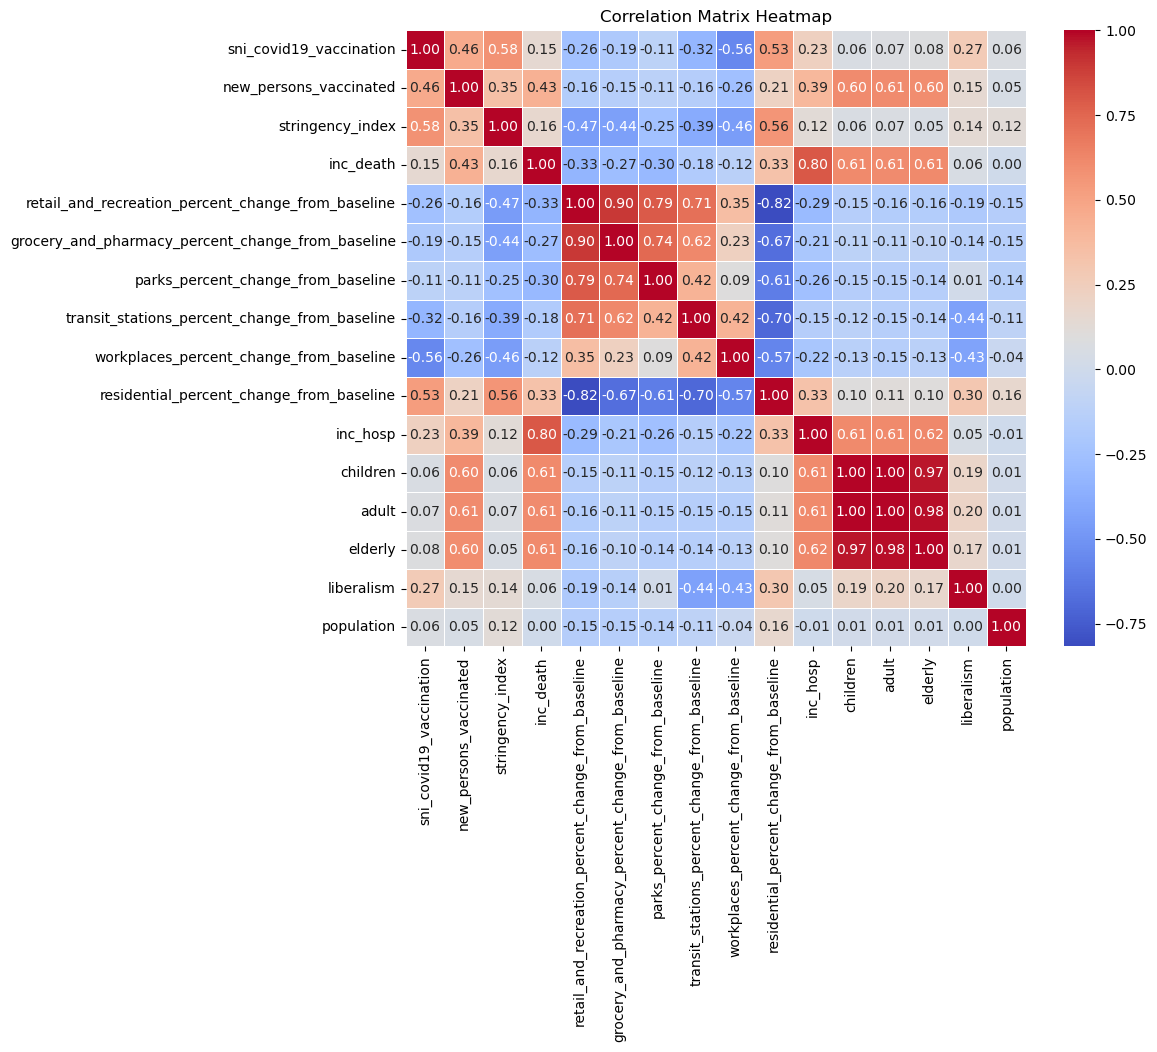

In [149]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap showing correlation matrix is decent
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

/opt/anaconda3/envs/cssci/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/opt/anaconda3/envs/cssci/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


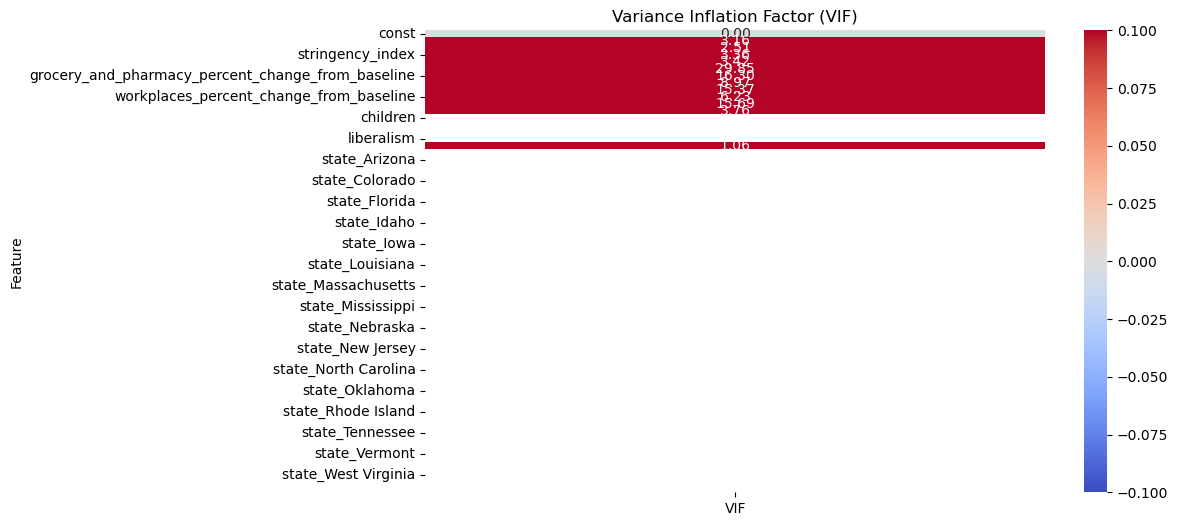

In [150]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF assess the multicollinearity between features
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

plt.figure(figsize=(10, 6))
sns.heatmap(vif_data.set_index('Feature'), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Variance Inflation Factor (VIF)")
plt.show()

#### **STEP 4: Evaluation metrics**

#### STEP 4.1: Monte Carlo Simulation

0 sni_covid19_vaccination
1 new_persons_vaccinated
2 stringency_index
3 inc_death
4 retail_and_recreation_percent_change_from_baseline
5 grocery_and_pharmacy_percent_change_from_baseline
6 parks_percent_change_from_baseline
7 transit_stations_percent_change_from_baseline
8 workplaces_percent_change_from_baseline
9 residential_percent_change_from_baseline
10 inc_hosp
11 children
12 adult
13 elderly
14 liberalism


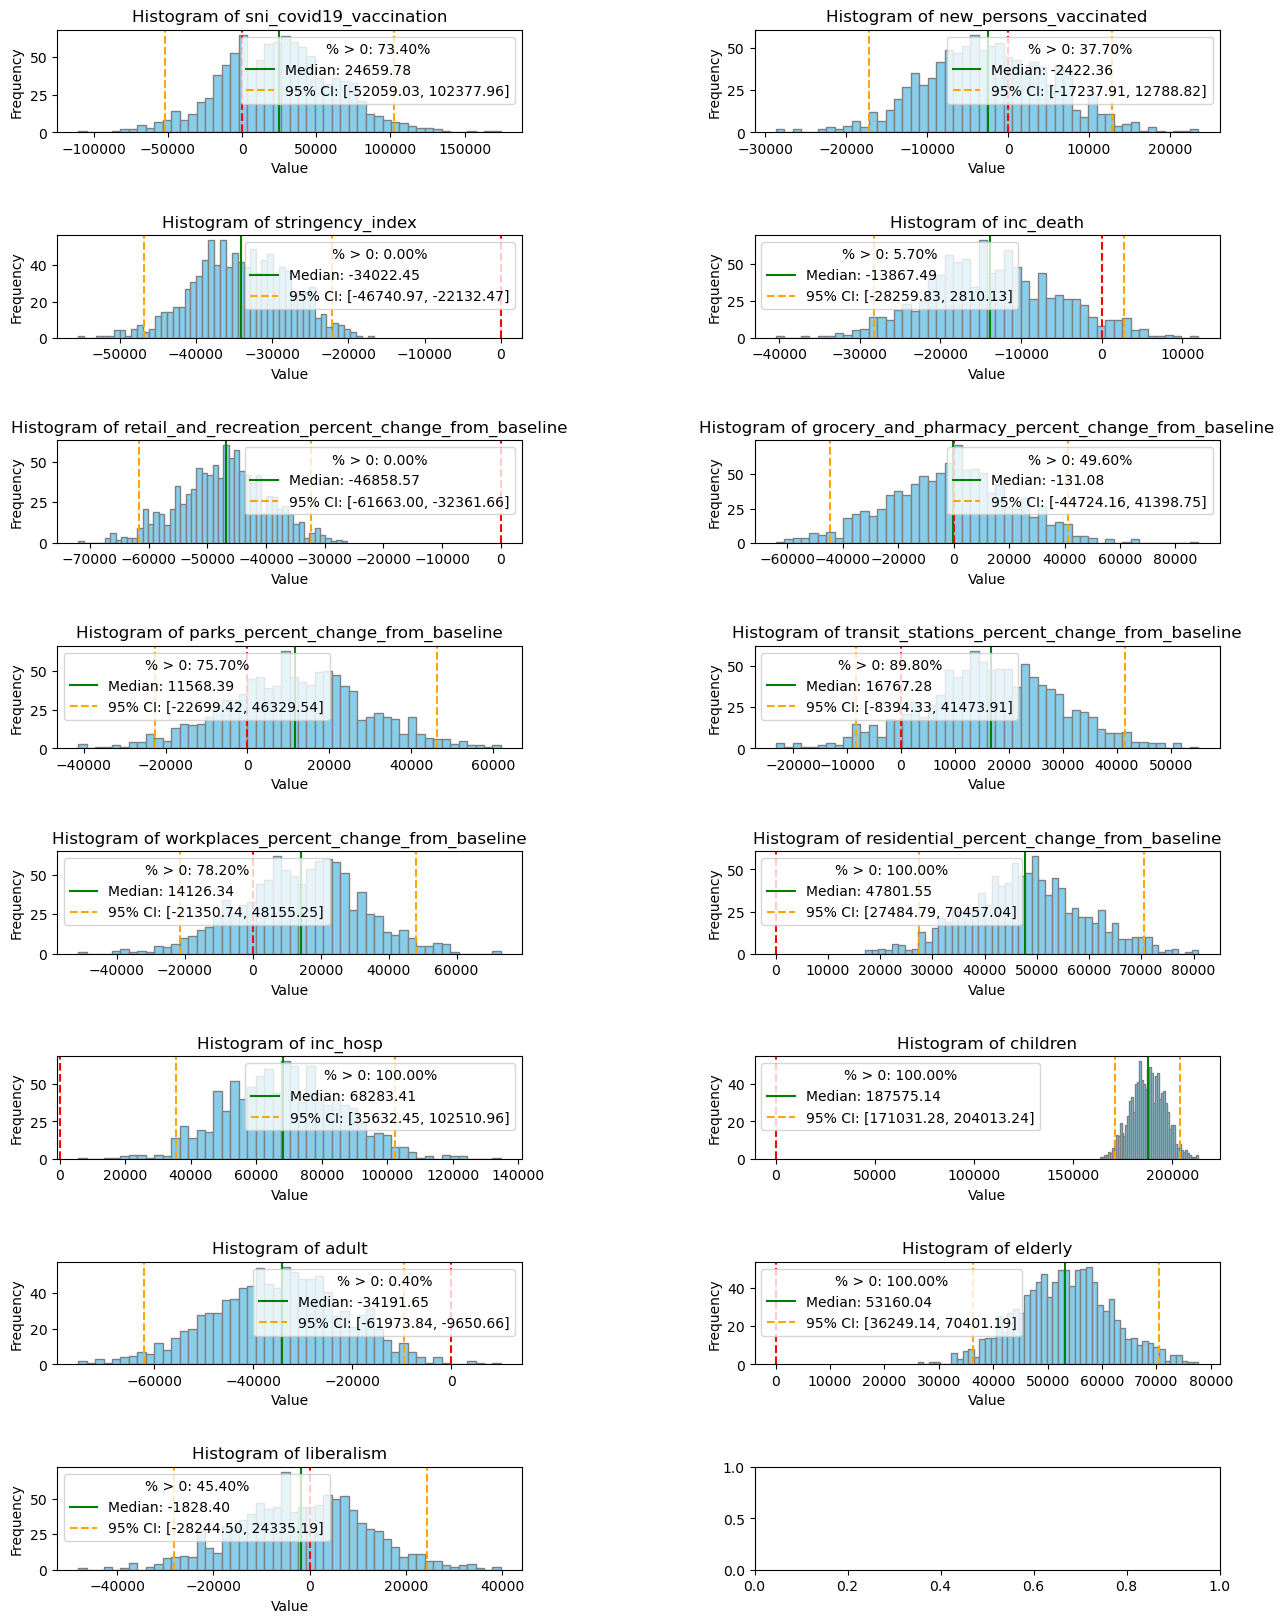

In [152]:
import matplotlib.pyplot as plt
import numpy as np

# Simulate values from empirical posterior distribution of model coefficients
n = 1000
coeff_samples = np.random.multivariate_normal(model.params, model.cov_params(), n)

#plot the histogram for each coefficient simulation
parameter_names = ['sni_covid19_vaccination','new_persons_vaccinated', 'stringency_index', 'inc_death',
                     'retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline',
                     'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline',
                     'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline',
                     'inc_hosp', 'children', 'adult', 'elderly', 'liberalism']
n_params = len(parameter_names)

fig, axs = plt.subplots(8, 2, figsize=(15, 20))
axes_flat = axs.flatten()

for i, name in enumerate(parameter_names):
    print(i, name)
    mean_val = np.mean(coeff_samples[:, i])
    median_val = np.median(coeff_samples[:, i])
    confidence_interval = np.percentile(coeff_samples[:, i], [2.5, 97.5])
    percent_positive = np.mean(coeff_samples[:, i] > 0) * 100  # Percentage of simulations > 0

    ax = axes_flat[i]
    ax.hist(coeff_samples[:, i], bins=50, color='skyblue', edgecolor='gray')
    ax.axvline(x=median_val, color='green', linestyle='-', label=f'Median: {median_val:.2f}')
    ax.axvline(x=confidence_interval[0], color='orange', linestyle='--', label=f'95% CI: [{confidence_interval[0]:.2f}, {confidence_interval[1]:.2f}]')
    ax.axvline(x=confidence_interval[1], color='orange', linestyle='--')
    ax.axvline(x=0, color='red', linestyle='--')
    ax.set_title(f'Histogram of {name}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend(title=f'% > 0: {percent_positive:.2f}%')

plt.subplots_adjust(hspace=1, wspace=0.5) 
plt.show()

#### STEP 4.2: Observed vs. Predicted Values

In [153]:
import statsmodels.api as sm

# Step 1: Prepare the new dataset - remember to add a constant if your model includes an intercept
X_new = X
X_new_with_const = sm.add_constant(X_new)

# Step 2: Predict new values
new_predictions = model.predict(X_new_with_const)

# Step 3: Calculate standard errors of the predictions
cov_matrix = model.cov_params()
design_matrix = X_new_with_const
variances = np.diag(np.dot(np.dot(design_matrix, cov_matrix), design_matrix.T))
std_errors_predictions = np.sqrt(variances)

# Generate posterior samples
new_predictions_array = np.array(new_predictions)[:, None]  # Convert to numpy array and add new axis
std_errors_predictions_array = np.array(std_errors_predictions)[:, None]  # Convert to numpy array and add new axis

predicted_samples = np.random.normal(loc=new_predictions_array,
                                     scale=std_errors_predictions_array,
                                     size=(new_predictions.shape[0], 1000))

monte_carlo_medians = np.median(predicted_samples, axis=1)
prediction_intervals = np.percentile(predicted_samples, [2.5, 97.5], axis=1)


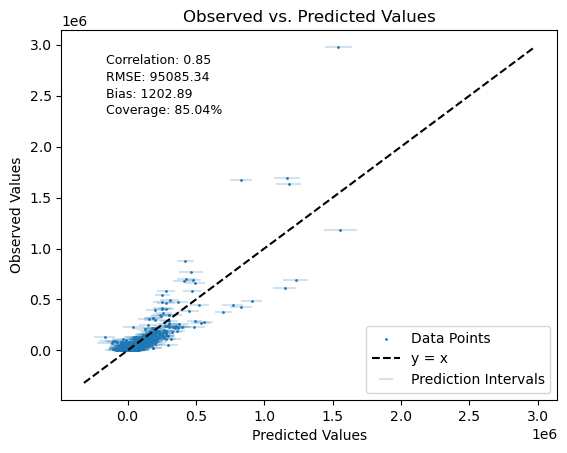

In [154]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Calculate metrics
correlation = np.corrcoef(monte_carlo_medians, y)[0, 1]
rmse = np.sqrt(mean_squared_error(y, monte_carlo_medians))
bias = np.mean(monte_carlo_medians - y)  # Mean prediction error
coverage = np.mean((y >= prediction_intervals[0,:]) & (y <= prediction_intervals[1,:]))

# # # Find overall min and max for xlim and ylim

# Flatten predicted_samples to make it 1-dimensional
predicted_samples_flat = predicted_samples.flatten()

# Concatenate the flattened predicted_samples with y
combined_array = np.concatenate([predicted_samples_flat, y])

# calculate min and max
min_val = combined_array.min()
max_val = combined_array.max()

# Plotting
scatter = plt.scatter(monte_carlo_medians, y, s=1, alpha=1, label='Data Points')
errorbar = plt.errorbar(monte_carlo_medians, y, xerr=np.abs(prediction_intervals - monte_carlo_medians), fmt='none', alpha=0.2, label='Prediction Intervals')
y_equals_x = plt.plot([min_val, max_val], [min_val, max_val], 'k--', zorder=3, label='y = x')

# Add legend with metrics
legend_labels = [
    f'Correlation: {correlation:.2f}',
    f'RMSE: {rmse:.2f}',
    f'Bias: {bias:.2f}',
    f'Coverage: {coverage:.2%}'
]

# Add legend for plot elements
plt.legend(loc='lower right')

# Text annotations for metrics
text_x = min_val + (max_val - min_val) * 0.05  # Adjust these positions as necessary
text_y_start = max_val - (max_val - min_val) * 0.05  # Starting y position for text
line_height = (max_val - min_val) * 0.05  # Adjust line height as necessary

for i, label in enumerate(legend_labels):
    plt.text(text_x, text_y_start - i * line_height, label, fontsize=9)

plt.title('Observed vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Observed Values')
plt.show()


#### **STEP 5: Fit data to a linear regression model without highly correlated covariates**

In [155]:
import statsmodels.api as sm

merged_df_final = pd.read_csv('merged_df_final.csv')

state_dummies = pd.get_dummies(merged_df_final['location_key'], prefix ='state', drop_first=True)
merged_df_final = pd.concat([merged_df_final, state_dummies], axis=1)

# Define your design matrix and your target variable 
X = merged_df_final[['sni_covid19_vaccination','new_persons_vaccinated', 'stringency_index', 'inc_death',
                     'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline',
                     'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline',
                     'inc_hosp', 'children', 'adult', 'elderly', 'liberalism', 'population'] + state_dummies.columns.tolist()].astype(float)
y = merged_df_final['inc_case']

# Add a constant to the features to account for the intercept in the model
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               inc_case   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     34.65
Date:                Wed, 05 Jun 2024   Prob (F-statistic):          1.42e-179
Time:                        22:42:20   Log-Likelihood:                -10926.
No. Observations:                 849   AIC:                         2.197e+04
Df Residuals:                     789   BIC:                         2.226e+04
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

#### STEP 5.1: Correlation Matrix

In [157]:
merged_df_final = merged_df_final.select_dtypes(include=['float64', 'int64'])

selected_columns = ['sni_covid19_vaccination','new_persons_vaccinated', 'stringency_index', 'inc_death',
                     'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline',
                     'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline',
                     'inc_hosp', 'children', 'adult', 'elderly', 'liberalism', 'population']
selected_df = merged_df_final[selected_columns]

# Calculate the correlation matrix
corr_matrix = selected_df.corr()
display("Correlation Matrix:", corr_matrix)

'Correlation Matrix:'

,sni_covid19_vaccination,new_persons_vaccinated,stringency_index,inc_death,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,inc_hosp,children,adult,elderly,liberalism,population
sni_covid19_vaccination,1.000000,0.460538,0.575775,0.150356,-0.110156,-0.323639,-0.559521,0.530789,0.232978,0.059262,0.074221,0.081586,0.270543,0.064226
new_persons_vaccinated,0.460538,1.000000,0.345121,0.426688,-0.114944,-0.155929,-0.257843,0.214397,0.393116,0.602626,0.608118,0.601990,0.151054,0.045015
stringency_index,0.575775,0.345121,1.000000,0.163502,-0.253175,-0.386528,-0.460182,0.560427,0.120909,0.057684,0.068412,0.052989,0.137746,0.122066
inc_death,0.150356,0.426688,0.163502,1.000000,-0.301065,-0.175664,-0.123934,0.330533,0.797084,0.610680,0.607891,0.614498,0.055461,0.003028
parks_percent_change_from_baseline,-0.110156,-0.114944,-0.253175,-0.301065,1.000000,0.422421,0.092519,-0.606881,-0.260285,-0.150084,-0.145734,-0.144622,0.010581,-0.136426
transit_stations_percent_change_from_baseline,-0.323639,-0.155929,-0.386528,-0.175664,0.422421,1.000000,0.421638,-0.702380,-0.152402,-0.121496,-0.145536,-0.143749,-0.438402,-0.105730
workplaces_percent_change_from_baseline,-0.559521,-0.257843,-0.460182,-0.123934,0.092519,0.421638,1.000000,-0.573438,-0.216419,-0.132361,-0.145221,-0.125771,-0.430198,-0.038344
residential_percent_change_from_baseline,0.530789,0.214397,0.560427,0.330533,-0.606881,-0.702380,-0.573438,1.000000,0.327832,0.097733,0.106292,0.098877,0.297916,0.163366
inc_hosp,0.232978,0.393116,0.120909,0.797084,-0.260285,-0.152402,-0.216419,0.327832,1.000000,0.612639,0.611148,0.622684,0.047471,-0.005146
children,0.059262,0.602626,0.057684,0.610680,-0.150084,-0.121496,-0.132361,0.097733,0.612639,1.000000,0.995791,0.965857,0.190184,0.006889


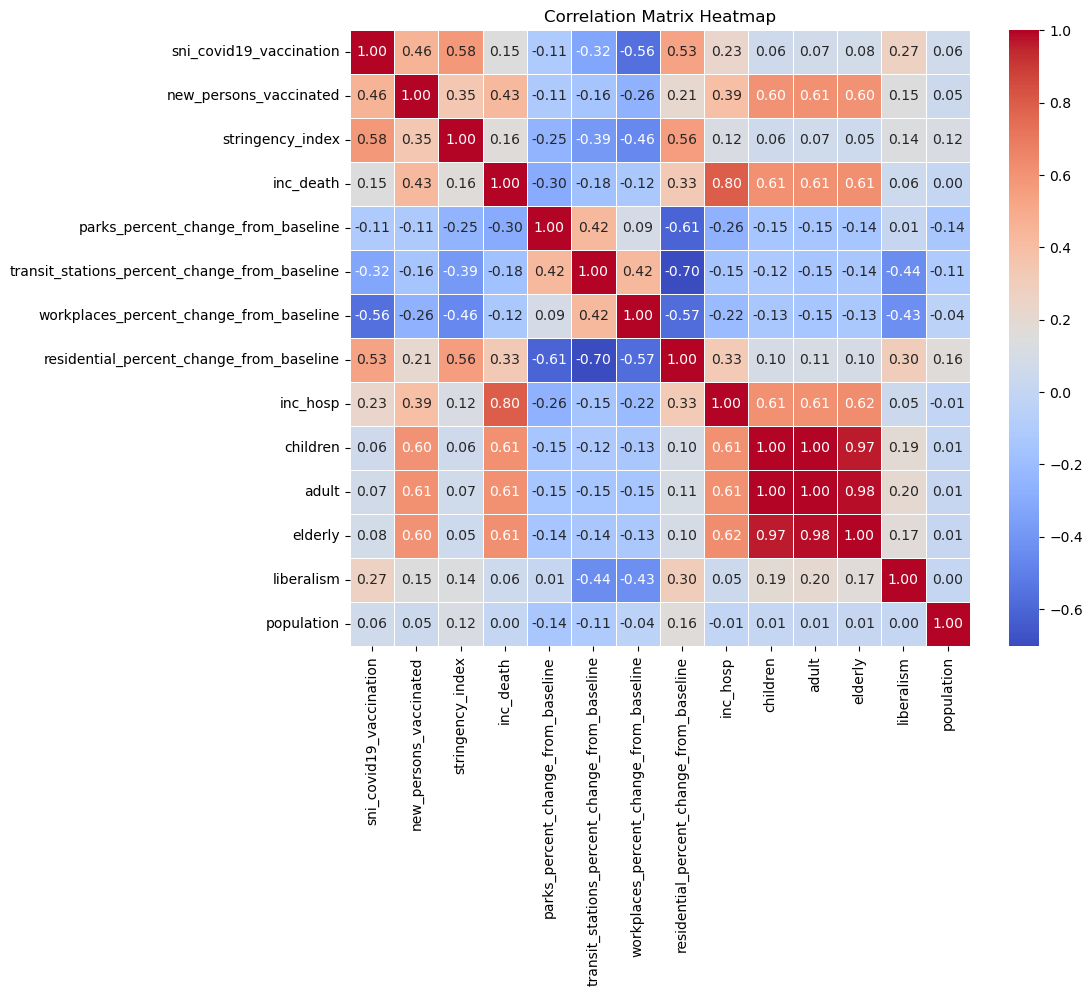

In [158]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap showing correlation matrix is decent
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

#### STEP 5.2: Monte Carlo Simulation

0 sni_covid19_vaccination
1 new_persons_vaccinated
2 stringency_index
3 inc_death
4 parks_percent_change_from_baseline
5 transit_stations_percent_change_from_baseline
6 workplaces_percent_change_from_baseline
7 residential_percent_change_from_baseline
8 inc_hosp
9 children
10 adult
11 elderly
12 liberalism


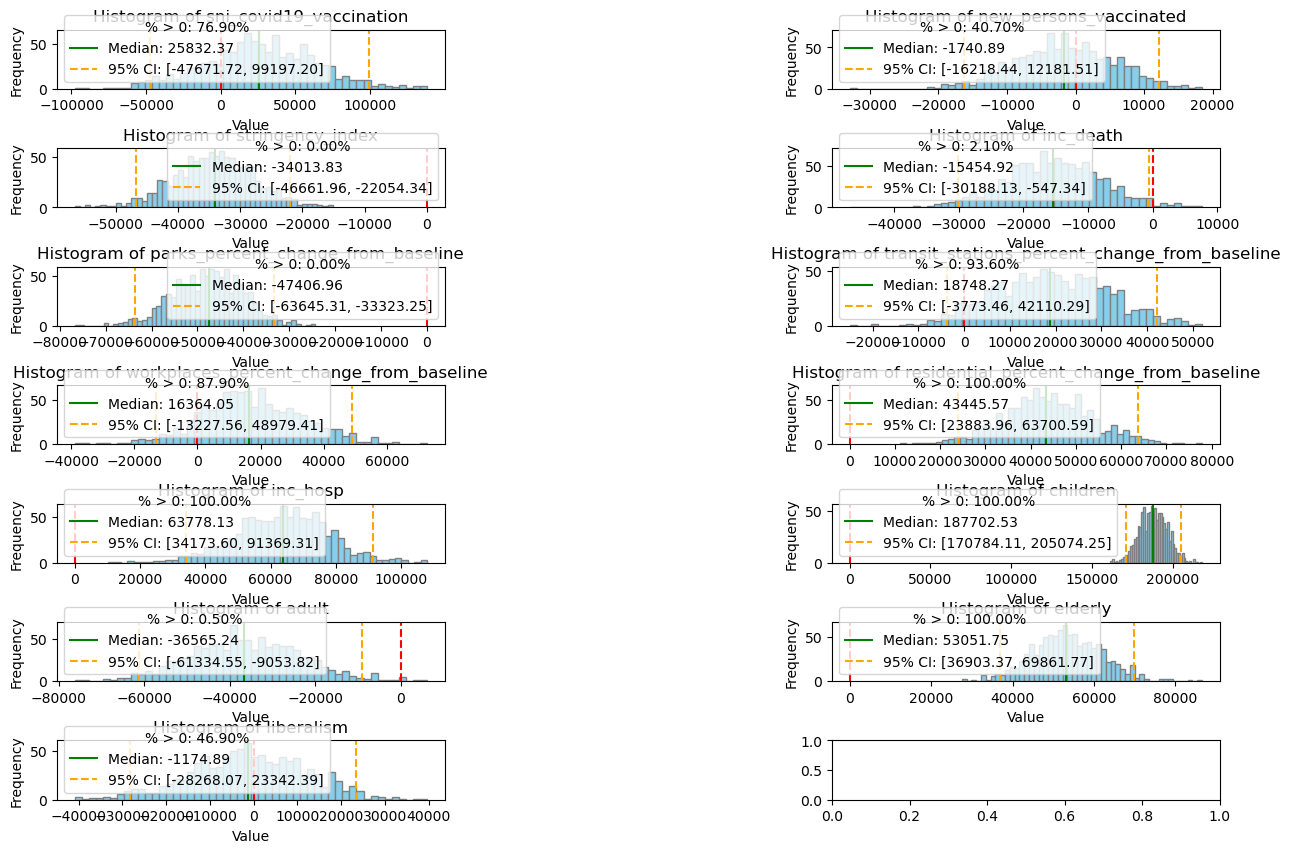

In [159]:
import matplotlib.pyplot as plt
import numpy as np

# Simulate values from empirical posterior distribution of model coefficients
n = 1000
coeff_samples = np.random.multivariate_normal(model.params, model.cov_params(), n)

#plot the histogram for each coefficient simulation
parameter_names = ['sni_covid19_vaccination','new_persons_vaccinated', 'stringency_index', 'inc_death',
                     'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline',
                     'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline',
                     'inc_hosp', 'children', 'adult', 'elderly', 'liberalism']
n_params = len(parameter_names)

fig, axs = plt.subplots(7, 2, figsize=(15, 10))
axes_flat = axs.flatten()

for i, name in enumerate(parameter_names):
    print(i, name)
    mean_val = np.mean(coeff_samples[:, i])
    median_val = np.median(coeff_samples[:, i])
    confidence_interval = np.percentile(coeff_samples[:, i], [2.5, 97.5])
    percent_positive = np.mean(coeff_samples[:, i] > 0) * 100  # Percentage of simulations > 0

    ax = axes_flat[i]
    ax.hist(coeff_samples[:, i], bins=50, color='skyblue', edgecolor='gray')
    ax.axvline(x=median_val, color='green', linestyle='-', label=f'Median: {median_val:.2f}')
    ax.axvline(x=confidence_interval[0], color='orange', linestyle='--', label=f'95% CI: [{confidence_interval[0]:.2f}, {confidence_interval[1]:.2f}]')
    ax.axvline(x=confidence_interval[1], color='orange', linestyle='--')
    ax.axvline(x=0, color='red', linestyle='--')
    ax.set_title(f'Histogram of {name}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend(title=f'% > 0: {percent_positive:.2f}%')

plt.subplots_adjust(hspace=1, wspace=1)
plt.show()

#### STEP 5.3: Observed vs. Predicted Values

In [160]:
import statsmodels.api as sm

# Step 1: Prepare the new dataset - remember to add a constant if your model includes an intercept
X_new = X
X_new_with_const = sm.add_constant(X_new)

# Step 2: Predict new values
new_predictions = model.predict(X_new_with_const)

# Step 3: Calculate standard errors of the predictions
cov_matrix = model.cov_params()
design_matrix = X_new_with_const
variances = np.diag(np.dot(np.dot(design_matrix, cov_matrix), design_matrix.T))
std_errors_predictions = np.sqrt(variances)

# Generate posterior samples
new_predictions_array = np.array(new_predictions)[:, None]  # Convert to numpy array and add new axis
std_errors_predictions_array = np.array(std_errors_predictions)[:, None]  # Convert to numpy array and add new axis

predicted_samples = np.random.normal(loc=new_predictions_array,
                                     scale=std_errors_predictions_array,
                                     size=(new_predictions.shape[0], 1000))

monte_carlo_medians = np.median(predicted_samples, axis=1)
prediction_intervals = np.percentile(predicted_samples, [2.5, 97.5], axis=1)


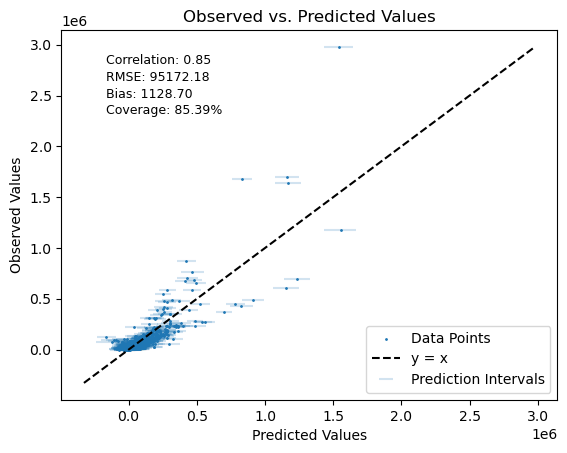

In [161]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Calculate metrics
correlation = np.corrcoef(monte_carlo_medians, y)[0, 1]
rmse = np.sqrt(mean_squared_error(y, monte_carlo_medians))
bias = np.mean(monte_carlo_medians - y)  # Mean prediction error
coverage = np.mean((y >= prediction_intervals[0,:]) & (y <= prediction_intervals[1,:]))

# # # Find overall min and max for xlim and ylim

# Flatten predicted_samples to make it 1-dimensional
predicted_samples_flat = predicted_samples.flatten()

# Concatenate the flattened predicted_samples with y
combined_array = np.concatenate([predicted_samples_flat, y])

# calculate min and max
min_val = combined_array.min()
max_val = combined_array.max()

# Plotting
scatter = plt.scatter(monte_carlo_medians, y, s=1, alpha=1, label='Data Points')
errorbar = plt.errorbar(monte_carlo_medians, y, xerr=np.abs(prediction_intervals - monte_carlo_medians), fmt='none', alpha=0.2, label='Prediction Intervals')
y_equals_x = plt.plot([min_val, max_val], [min_val, max_val], 'k--', zorder=3, label='y = x')

# Add legend with metrics
legend_labels = [
    f'Correlation: {correlation:.2f}',
    f'RMSE: {rmse:.2f}',
    f'Bias: {bias:.2f}',
    f'Coverage: {coverage:.2%}'
]

# Add legend for plot elements
plt.legend(loc='lower right')

# Text annotations for metrics
text_x = min_val + (max_val - min_val) * 0.05  # Adjust these positions as necessary
text_y_start = max_val - (max_val - min_val) * 0.05  # Starting y position for text
line_height = (max_val - min_val) * 0.05  # Adjust line height as necessary

for i, label in enumerate(legend_labels):
    plt.text(text_x, text_y_start - i * line_height, label, fontsize=9)

plt.title('Observed vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Observed Values')
plt.show()


#### **STEP 6: Try PCA instead for the mobility variables**

#### STEP 6.1: Reduce dimensionality

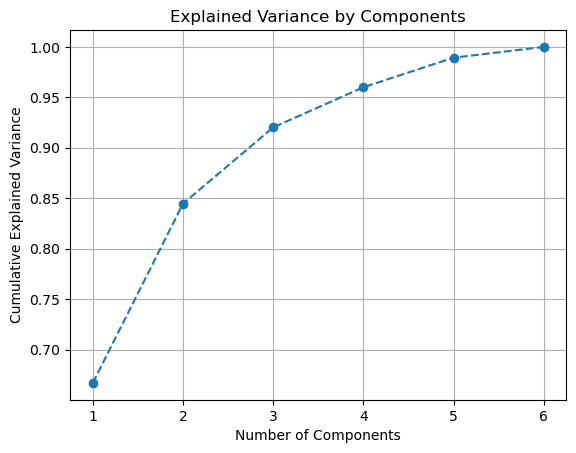

In [162]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

mobility_variables = ['retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline',
                     'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline',
                     'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline']

X = merged_df_final[mobility_variables]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Determine the number of components
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance.cumsum()

# Plot the explained variance
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.show()

In [163]:
n_components = 3
mobility_reduced = X_pca[:, :n_components]
mobility_reduced_df = pd.DataFrame(mobility_reduced, columns=[f'PC{i+1}' for i in range(n_components)])

In [164]:
display(mobility_reduced_df.head()) 

,PC1,PC2,PC3
0,-2.396417,-0.262114,-0.155315
1,-3.198032,0.417148,0.067946
2,-3.498723,0.562954,-1.172292
3,-2.131540,-0.503742,-0.223589
4,-5.161720,1.488413,-0.310348


In [165]:
# Add mobility reduced to the dataframe
merged_df_final = pd.read_csv('merged_df_final.csv')
merged_df_final = pd.concat([merged_df_final, mobility_reduced_df], axis=1)

display(merged_df_final.head())

,date,location_key,inc_case,inc_hosp,inc_death,sni_covid19_vaccination,liberalism,children,adult,elderly,...,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,population,PC1,PC2,PC3
0,2021-01,Alabama,112124.0,1.371155,1.584112,0.032568,0.0,-0.231951,-0.237370,-0.199080,...,-1.154831,-1.239613,-1.010675,-0.710112,-0.403022,1.149867,-0.215768,-2.396417,-0.262114,-0.155315
1,2021-01,Alaska,8604.0,-0.537244,-0.539897,1.080654,1.0,-0.755107,-0.762349,-0.849780,...,-1.258975,-1.399782,-0.904952,-1.316842,-0.913240,1.939921,-0.215768,-3.198032,0.417148,0.067946
2,2021-01,Arizona,262750.0,2.366892,2.944381,1.492130,1.0,0.135100,0.059541,0.166176,...,-1.630906,-1.785018,-1.153541,-0.303895,-1.669627,2.105210,-0.215768,-3.498723,0.562954,-1.172292
3,2021-01,Arkansas,80418.0,0.281742,0.466371,0.247917,0.0,-0.458891,-0.484278,-0.474223,...,-1.131391,-1.283933,-0.874682,-0.393830,-0.124464,1.092664,-0.215768,-2.131540,-0.503742,-0.223589
4,2021-01,California,1180351.0,10.206922,11.821532,1.098149,1.0,4.449814,4.491572,4.087480,...,-2.567884,-2.012602,-1.050743,-1.861609,-2.430059,2.871310,-0.215768,-5.161720,1.488413,-0.310348


In [166]:
merged_df_final.to_csv('PCA_final.csv', index=False)

#### STEP 6.2: Fit the model with reduced mobility data 

In [167]:
import statsmodels.api as sm

state_dummies = pd.get_dummies(merged_df_final['location_key'], prefix ='state', drop_first=True)
merged_df_final = pd.concat([merged_df_final, state_dummies], axis=1)

# Define your design matrix and your target variable 
X = merged_df_final[['sni_covid19_vaccination','new_persons_vaccinated', 'stringency_index', 'inc_death',
                     'PC1', 'PC2', 'PC3', 'inc_hosp', 'children', 'adult', 'elderly', 'liberalism', 'population'] + state_dummies.columns.tolist()].astype(float)
y = merged_df_final['inc_case']

# Add a constant to the features to account for the intercept in the model
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               inc_case   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     33.13
Date:                Wed, 05 Jun 2024   Prob (F-statistic):          8.30e-173
Time:                        22:42:22   Log-Likelihood:                -10945.
No. Observations:                 849   AIC:                         2.201e+04
Df Residuals:                     790   BIC:                         2.229e+04
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    4

#### STEP 6.3: Correlation matrix

In [169]:
merged_df_final = merged_df_final.select_dtypes(include=['float64', 'int64'])

selected_columns = ['sni_covid19_vaccination','new_persons_vaccinated', 'stringency_index', 'inc_death',
                     'PC1', 'PC2', 'PC3', 'inc_hosp', 'children', 'adult', 'elderly', 'liberalism', 'population']
selected_df = merged_df_final[selected_columns]

# Calculate the correlation matrix
corr_matrix = selected_df.corr()
display("Correlation Matrix:", corr_matrix)

'Correlation Matrix:'

,sni_covid19_vaccination,new_persons_vaccinated,stringency_index,inc_death,PC1,PC2,PC3,inc_hosp,children,adult,elderly,liberalism,population
sni_covid19_vaccination,1.000000,0.460538,0.575775,0.150356,-3.763582e-01,4.627093e-01,-1.266680e-01,0.232978,0.059262,0.074221,0.081586,0.270543,0.064226
new_persons_vaccinated,0.460538,1.000000,0.345121,0.426688,-2.038886e-01,1.579703e-01,-8.405393e-02,0.393116,0.602626,0.608118,0.601990,0.151054,0.045015
stringency_index,0.575775,0.345121,1.000000,0.163502,-5.190210e-01,2.451638e-01,-8.114982e-02,0.120909,0.057684,0.068412,0.052989,0.137746,0.122066
inc_death,0.150356,0.426688,0.163502,1.000000,-3.236687e-01,-5.520823e-02,-1.150376e-01,0.797084,0.610680,0.607891,0.614498,0.055461,0.003028
PC1,-0.376358,-0.203889,-0.519021,-0.323669,1.000000e+00,-1.344185e-16,3.449240e-17,-0.298124,-0.152389,-0.162441,-0.155240,-0.281751,-0.158674
PC2,0.462709,0.157970,0.245164,-0.055208,-1.344185e-16,1.000000e+00,-3.387469e-16,0.049788,0.027647,0.044135,0.030979,0.414267,-0.037059
PC3,-0.126668,-0.084054,-0.081150,-0.115038,3.449240e-17,-3.387469e-16,1.000000e+00,-0.175057,-0.050061,-0.028665,-0.017137,0.205408,-0.011828
inc_hosp,0.232978,0.393116,0.120909,0.797084,-2.981244e-01,4.978780e-02,-1.750566e-01,1.000000,0.612639,0.611148,0.622684,0.047471,-0.005146
children,0.059262,0.602626,0.057684,0.610680,-1.523885e-01,2.764725e-02,-5.006109e-02,0.612639,1.000000,0.995791,0.965857,0.190184,0.006889
adult,0.074221,0.608118,0.068412,0.607891,-1.624414e-01,4.413465e-02,-2.866504e-02,0.611148,0.995791,1.000000,0.981251,0.202172,0.009956


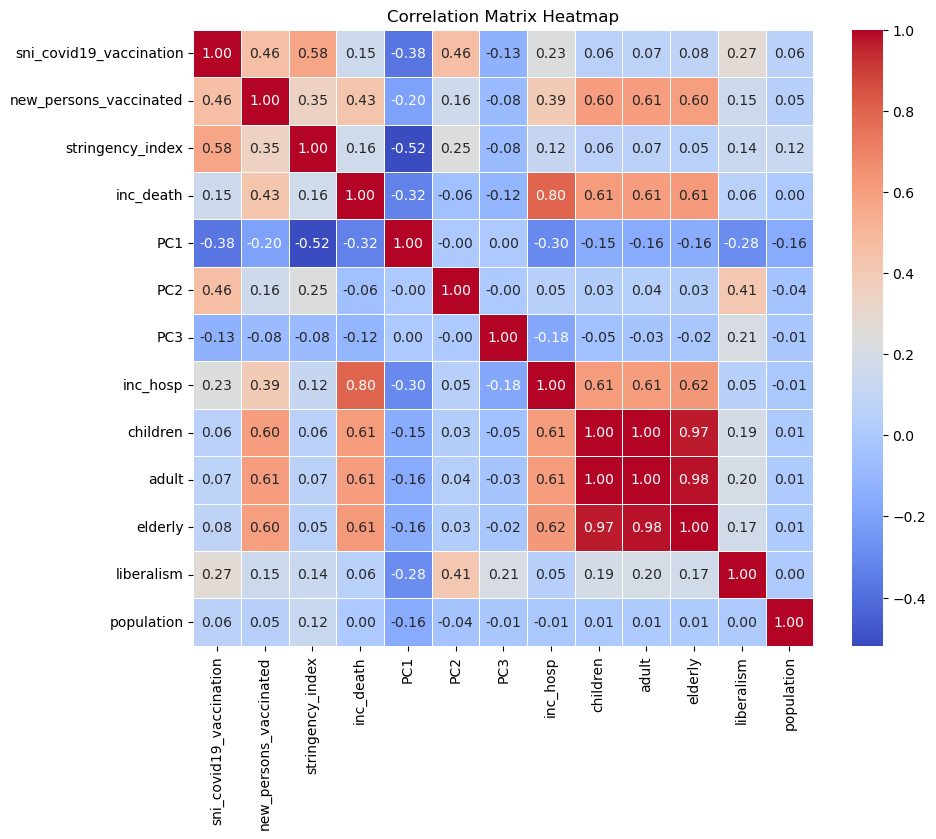

In [170]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap showing correlation matrix is decent
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

#### STEP 6.4: Monte Carlo Simulation

0 sni_covid19_vaccination
1 new_persons_vaccinated
2 stringency_index
3 inc_death
4 PC1
5 PC2
6 PC3
7 new_hospitalized_patients
8 children
9 adult
10 elderly
11 liberalism
12 population


IndexError: index 12 is out of bounds for axis 0 with size 12

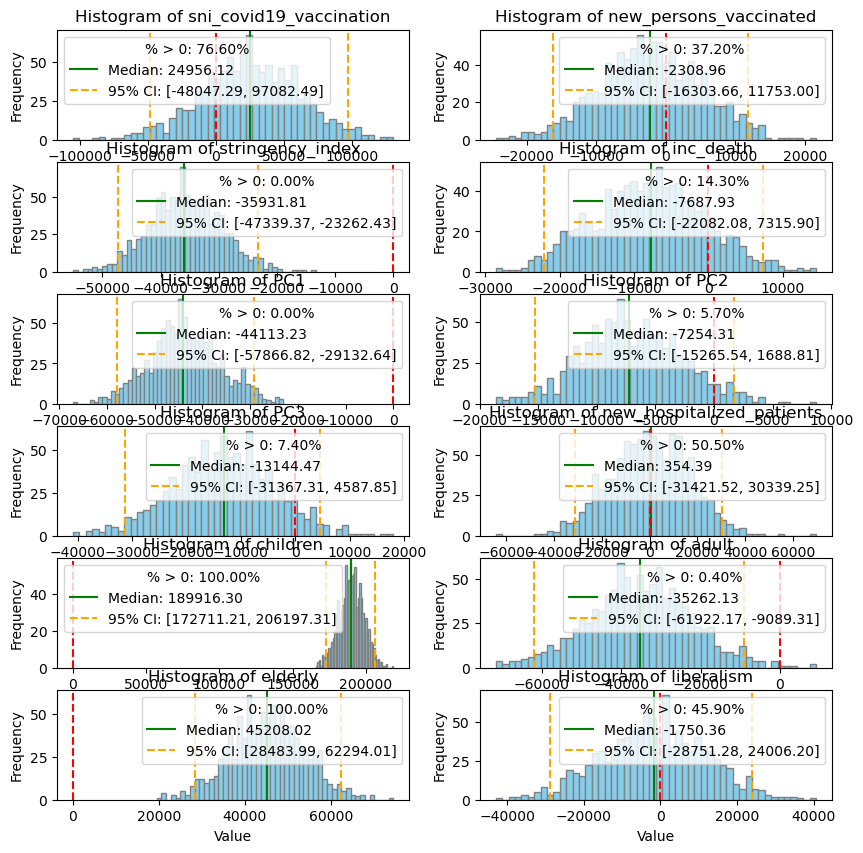

In [171]:
import matplotlib.pyplot as plt
import numpy as np

# Simulate values from empirical posterior distribution of model coefficients
n = 1000
coeff_samples = np.random.multivariate_normal(model.params, model.cov_params(), n)

#plot the histogram for each coefficient simulation
parameter_names = ['sni_covid19_vaccination','new_persons_vaccinated', 'stringency_index', 'inc_death',
        'PC1', 'PC2', 'PC3', 'new_hospitalized_patients', 'children', 'adult', 'elderly', 'liberalism', 'population']
n_params = len(parameter_names)

fig, axs = plt.subplots(6, 2, figsize=(10, 10))
axes_flat = axs.flatten()

for i, name in enumerate(parameter_names):
    print(i, name)
    mean_val = np.mean(coeff_samples[:, i])
    median_val = np.median(coeff_samples[:, i])
    confidence_interval = np.percentile(coeff_samples[:, i], [2.5, 97.5])
    percent_positive = np.mean(coeff_samples[:, i] > 0) * 100  # Percentage of simulations > 0

    ax = axes_flat[i]
    ax.hist(coeff_samples[:, i], bins=50, color='skyblue', edgecolor='gray')
    ax.axvline(x=median_val, color='green', linestyle='-', label=f'Median: {median_val:.2f}')
    ax.axvline(x=confidence_interval[0], color='orange', linestyle='--', label=f'95% CI: [{confidence_interval[0]:.2f}, {confidence_interval[1]:.2f}]')
    ax.axvline(x=confidence_interval[1], color='orange', linestyle='--')
    ax.axvline(x=0, color='red', linestyle='--')
    ax.set_title(f'Histogram of {name}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend(title=f'% > 0: {percent_positive:.2f}%')

plt.subplots_adjust(hspace=1, wspace=1)
plt.show()

#### STEP 6.5: Observed vs. Predicted Values

In [ ]:
import statsmodels.api as sm

# Step 1: Prepare the new dataset - remember to add a constant if your model includes an intercept
X_new = X
X_new_with_const = sm.add_constant(X_new)

# Step 2: Predict new values
new_predictions = model.predict(X_new_with_const)

# Step 3: Calculate standard errors of the predictions
cov_matrix = model.cov_params()
design_matrix = X_new_with_const
variances = np.diag(np.dot(np.dot(design_matrix, cov_matrix), design_matrix.T))
std_errors_predictions = np.sqrt(variances)

# Generate posterior samples
new_predictions_array = np.array(new_predictions)[:, None]  # Convert to numpy array and add new axis
std_errors_predictions_array = np.array(std_errors_predictions)[:, None]  # Convert to numpy array and add new axis

predicted_samples = np.random.normal(loc=new_predictions_array,
                                     scale=std_errors_predictions_array,
                                     size=(new_predictions.shape[0], 1000))

monte_carlo_medians = np.median(predicted_samples, axis=1)
prediction_intervals = np.percentile(predicted_samples, [2.5, 97.5], axis=1)

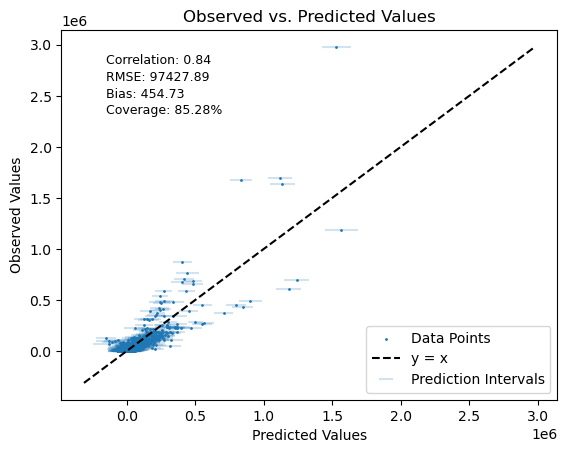

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Calculate metrics
correlation = np.corrcoef(monte_carlo_medians, y)[0, 1]
rmse = np.sqrt(mean_squared_error(y, monte_carlo_medians))
bias = np.mean(monte_carlo_medians - y)  # Mean prediction error
coverage = np.mean((y >= prediction_intervals[0,:]) & (y <= prediction_intervals[1,:]))

# # # Find overall min and max for xlim and ylim

# Flatten predicted_samples to make it 1-dimensional
predicted_samples_flat = predicted_samples.flatten()

# Concatenate the flattened predicted_samples with y
combined_array = np.concatenate([predicted_samples_flat, y])

# calculate min and max
min_val = combined_array.min()
max_val = combined_array.max()

# Plotting
scatter = plt.scatter(monte_carlo_medians, y, s=1, alpha=1, label='Data Points')
errorbar = plt.errorbar(monte_carlo_medians, y, xerr=np.abs(prediction_intervals - monte_carlo_medians), fmt='none', alpha=0.2, label='Prediction Intervals')
y_equals_x = plt.plot([min_val, max_val], [min_val, max_val], 'k--', zorder=3, label='y = x')

# Add legend with metrics
legend_labels = [
    f'Correlation: {correlation:.2f}',
    f'RMSE: {rmse:.2f}',
    f'Bias: {bias:.2f}',
    f'Coverage: {coverage:.2%}'
]

# Add legend for plot elements
plt.legend(loc='lower right')

# Text annotations for metrics
text_x = min_val + (max_val - min_val) * 0.05  # Adjust these positions as necessary
text_y_start = max_val - (max_val - min_val) * 0.05  # Starting y position for text
line_height = (max_val - min_val) * 0.05  # Adjust line height as necessary

for i, label in enumerate(legend_labels):
    plt.text(text_x, text_y_start - i * line_height, label, fontsize=9)

plt.title('Observed vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Observed Values')
plt.show()